--- Libraries installed ---
--- Setting up and isolating a single patient for analysis ---
Mounted at /content/drive
Selected Patient ID for analysis: 247


Loading data for Patient 247:   0%|          | 0/31 [00:00<?, ?it/s]

Successfully loaded 20116 data points for the patient.

--- Simulating online change point detection... ---


Processing Signal:   0%|          | 0/19816 [00:00<?, ?it/s]


--- Plotting the results... ---


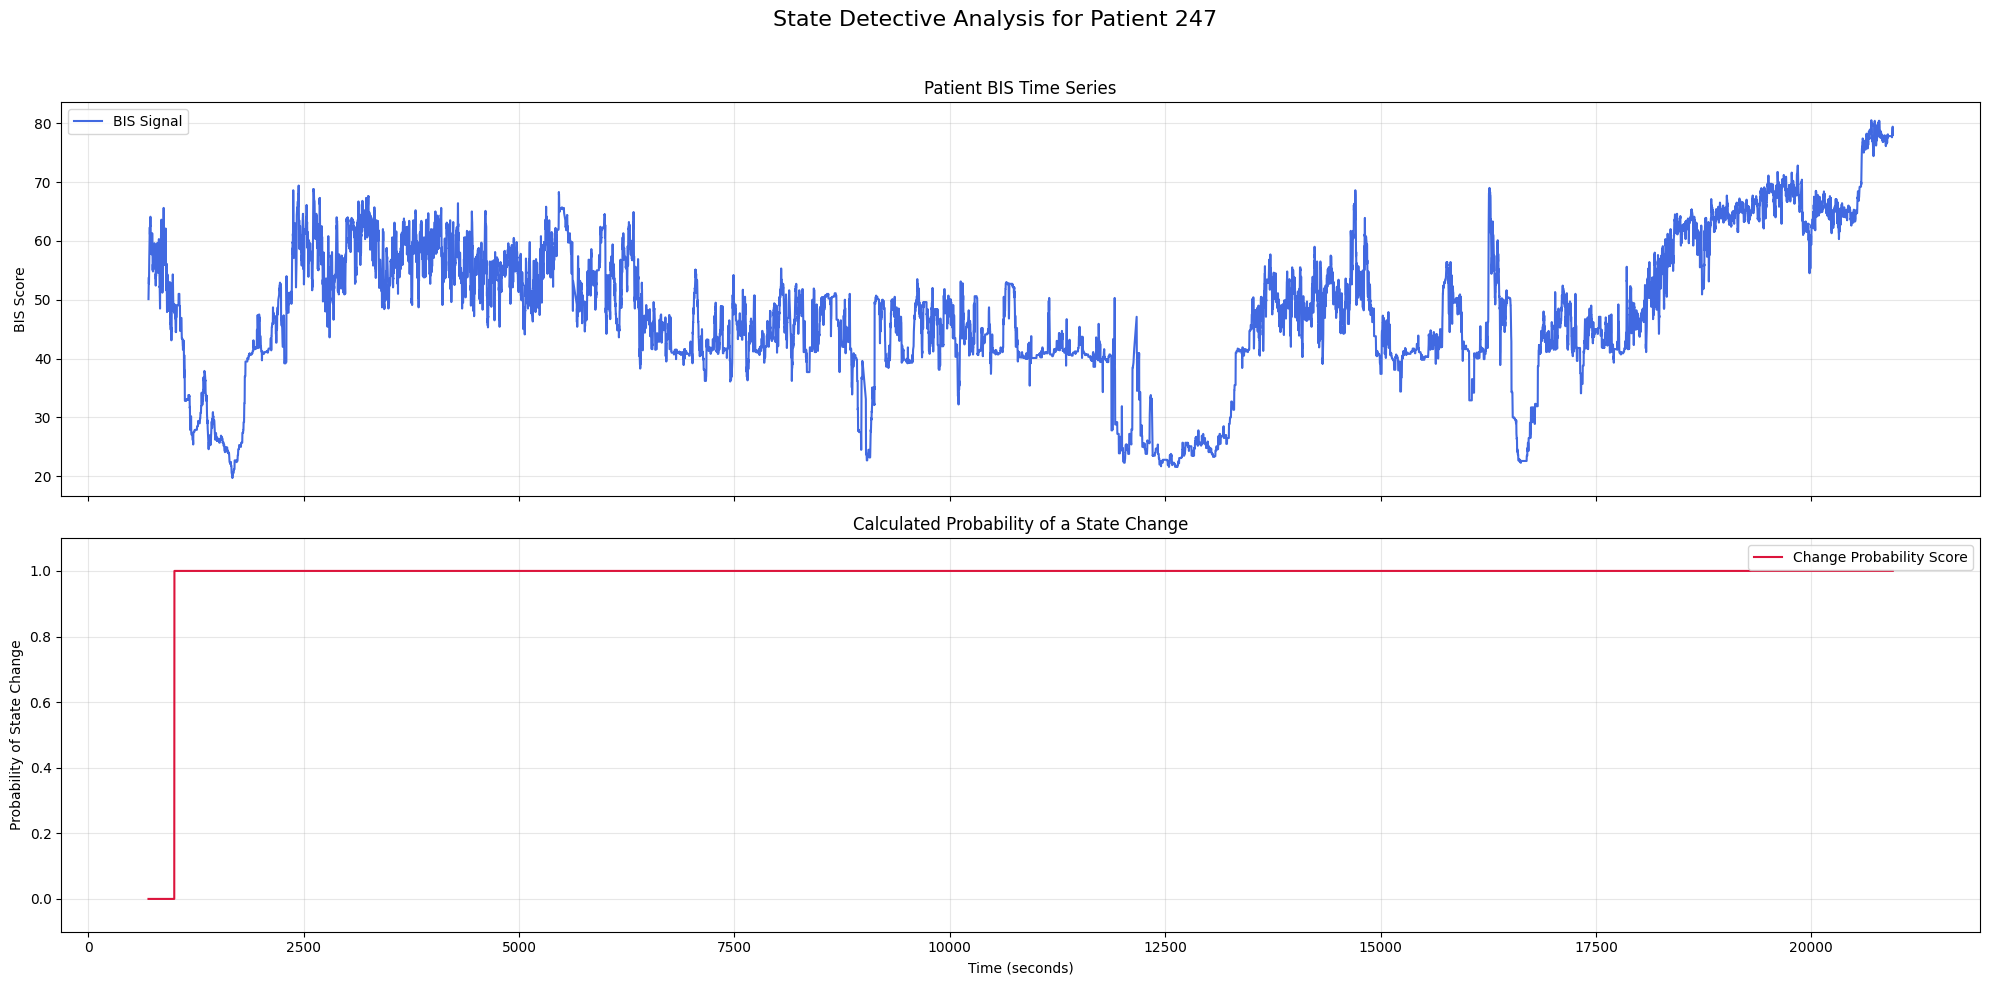

In [ ]:
# --- The State Detective: Change Point Detection Proof of Concept ---

# Step 1: Install necessary libraries
!pip install ruptures pandas numpy matplotlib seaborn google-colab --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

# --- 1. Setup and Isolate a Single Patient ---
print("--- Setting up and isolating a single patient for analysis ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))

# We need to find a patient from our validation set to serve as a test case
# Re-running the stratified split logic to get a consistent val_id
patient_row_counts = Counter()
for file_path in batch_files:
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())
patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')
_, val_ids = train_test_split(
    available_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)

# Let's pick a patient from the validation set for our case study
# Patient 247 was interesting before, let's see how this method works on them.
target_patient_id = 247
print(f"Selected Patient ID for analysis: {target_patient_id}")

# Load all data for this single patient
patient_df_list = []
for file_path in tqdm(batch_files, desc=f"Loading data for Patient {target_patient_id}"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    patient_chunk = df_chunk[df_chunk['patient_id'] == target_patient_id]
    if not patient_chunk.empty:
        patient_df_list.append(patient_chunk)

if not patient_df_list:
    raise ValueError(f"Could not find data for patient {target_patient_id}")

patient_df = pd.concat(patient_df_list).sort_values('Time')
# Extract the core signal we want to monitor
signal = patient_df['BIS/BIS'].values
print(f"Successfully loaded {len(signal)} data points for the patient.")


# --- 2. Online Change Point Detection Simulation ---
print("\n--- Simulating online change point detection... ---")

# Model configuration
# We'll use a Binary Segmentation search method within a sliding window.
# It looks for a change in the mean of the signal ("l2" cost model).
WINDOW_SIZE = 300  # Look at the last 5 minutes of data
PENALTY_VALUE = 3 # A tuning parameter for the algorithm's sensitivity

# Initialize the algorithm
algo = rpt.Binseg(model="l2").fit(signal)
change_scores = []

# This loop simulates real-time data arrival
for i in tqdm(range(WINDOW_SIZE, len(signal)), desc="Processing Signal"):
    # Define the current window of data
    current_window = signal[i-WINDOW_SIZE:i]

    # Ask the algorithm to find the most likely change point in this window
    # The result is the *index* of the change point within the window
    result = algo.predict(pen=PENALTY_VALUE, n_bkps=1)

    # Our "change score" is high if a change point is detected very recently
    # We check if the detected change point is in the last 10 seconds of the window
    # This is a simple way to create a "probability of recent change" score
    if result[0] > (WINDOW_SIZE - 10):
        change_scores.append(1.0) # High probability of a recent change
    else:
        change_scores.append(0.0) # Low probability

# Pad the start of the scores list so it aligns with the signal for plotting
change_scores = [0.0] * WINDOW_SIZE + change_scores


# --- 3. Visualize the Results ---
print("\n--- Plotting the results... ---")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
fig.suptitle(f'State Detective Analysis for Patient {target_patient_id}', fontsize=16)

# Plot 1: The original BIS signal
ax1.plot(patient_df['Time'], signal, label='BIS Signal', color='royalblue')
ax1.set_ylabel('BIS Score')
ax1.set_title('Patient BIS Time Series')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: The Change Point Probability Score
ax2.plot(patient_df['Time'], change_scores, label='Change Probability Score', color='crimson')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Probability of State Change')
ax2.set_title('Calculated Probability of a State Change')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(-0.1, 1.1) # Set y-axis from 0 to 1 for probability

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

--- Libraries installed ---
--- Setting up and isolating a single patient for analysis ---
Mounted at /content/drive
Selected Patient ID for analysis: 247


Loading data for Patient 247:   0%|          | 0/31 [00:00<?, ?it/s]

Successfully loaded 20116 data points for the patient.

--- Simulating online change point detection with Pelt/RBF... ---
Detected 90 significant change points.

--- Plotting the results... ---


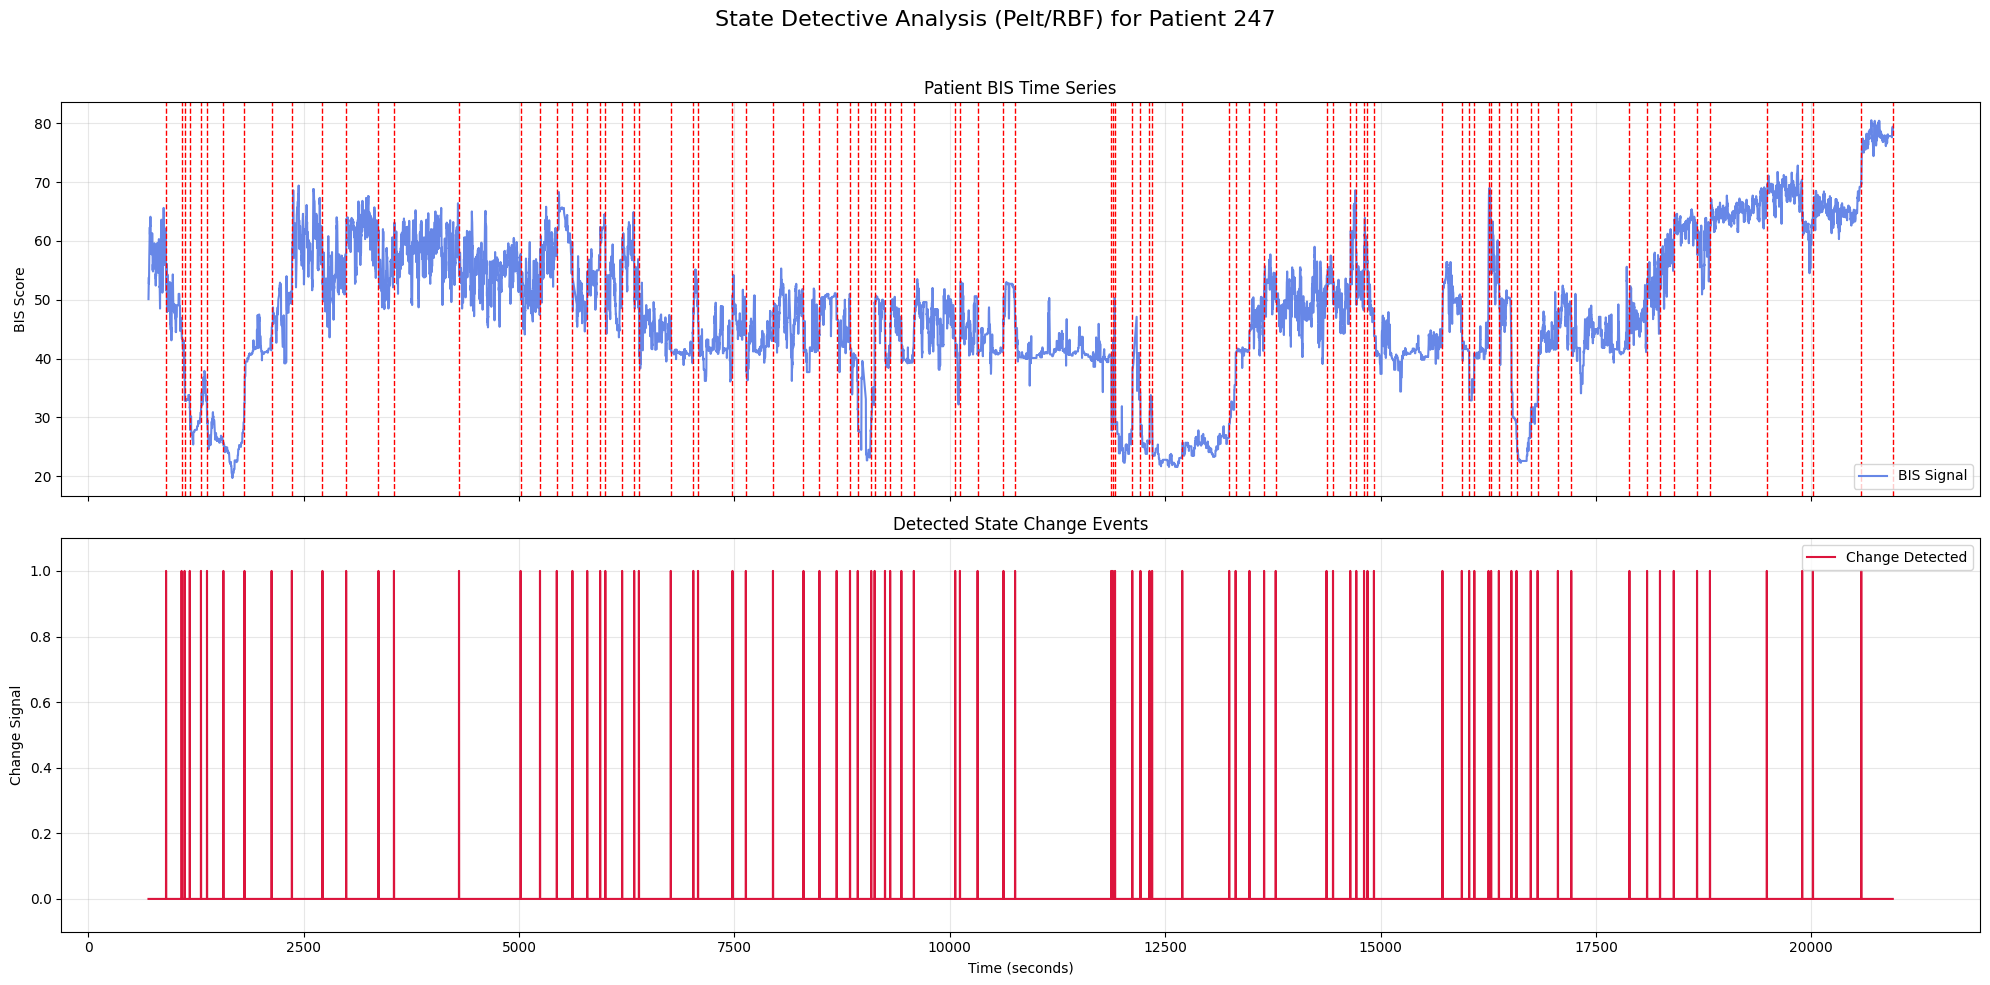

In [ ]:
# --- The State Detective: Change Point Detection v2 ---

# Step 1: Install necessary libraries
!pip install ruptures pandas numpy matplotlib seaborn google-colab --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

# --- 1. Setup and Isolate a Single Patient ---
print("--- Setting up and isolating a single patient for analysis ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))

# Re-run the stratified split logic to get a consistent val_id
patient_row_counts = Counter()
for file_path in batch_files:
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())
patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')
_, val_ids = train_test_split(
    available_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)

target_patient_id = 247
print(f"Selected Patient ID for analysis: {target_patient_id}")

# Load all data for this single patient
patient_df_list = []
for file_path in tqdm(batch_files, desc=f"Loading data for Patient {target_patient_id}"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    patient_chunk = df_chunk[df_chunk['patient_id'] == target_patient_id]
    if not patient_chunk.empty:
        patient_df_list.append(patient_chunk)

patient_df = pd.concat(patient_df_list).sort_values('Time')
signal = patient_df['BIS/BIS'].values
print(f"Successfully loaded {len(signal)} data points for the patient.")


# --- 2. Online Change Point Detection with the Correct Algorithm ---
print("\n--- Simulating online change point detection with Pelt/RBF... ---")

# THE FIX: Use an algorithm designed for online, multi-change detection
# Model: Pelt search method is optimal for finding multiple change points.
# Cost: "rbf" (Radial Basis Function) is more sensitive to changes in distribution than just the mean.
algo = rpt.Pelt(model="rbf").fit(signal)
change_points = algo.predict(pen=10) # Predict all significant change points in the signal

# Convert the list of change point locations into a time-series "probability" score for plotting
change_scores = np.zeros(len(signal))
for cp in change_points:
    if cp < len(signal):
        # Create a "spike" at the location of the change point
        change_scores[cp-1] = 1.0

print(f"Detected {len(change_points)-1} significant change points.")


# --- 3. Visualize the Results ---
print("\n--- Plotting the results... ---")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
fig.suptitle(f'State Detective Analysis (Pelt/RBF) for Patient {target_patient_id}', fontsize=16)

# Plot 1: The original BIS signal
ax1.plot(patient_df['Time'], signal, label='BIS Signal', color='royalblue', alpha=0.8)
ax1.set_ylabel('BIS Score')
ax1.set_title('Patient BIS Time Series')
ax1.grid(True, alpha=0.3)

# Overlay the detected change points as vertical lines for clarity
for cp in change_points:
    ax1.axvline(x=patient_df['Time'].iloc[cp-1], color='red', linestyle='--', linewidth=1)
ax1.legend()


# Plot 2: The Change Point "Spikes"
ax2.plot(patient_df['Time'], change_scores, label='Change Detected', color='crimson')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Change Signal')
ax2.set_title('Detected State Change Events')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(-0.1, 1.1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

--- Libraries installed ---
--- Setting up and isolating a single patient for analysis ---
Mounted at /content/drive
Selected Patient ID for analysis: 247


Loading data for Patient 247:   0%|          | 0/31 [00:00<?, ?it/s]

Successfully loaded 20116 data points for the patient.

--- Detecting major change points with a memory-efficient model... ---
Detected 1091 major change points with penalty=5.

--- Plotting the results... ---


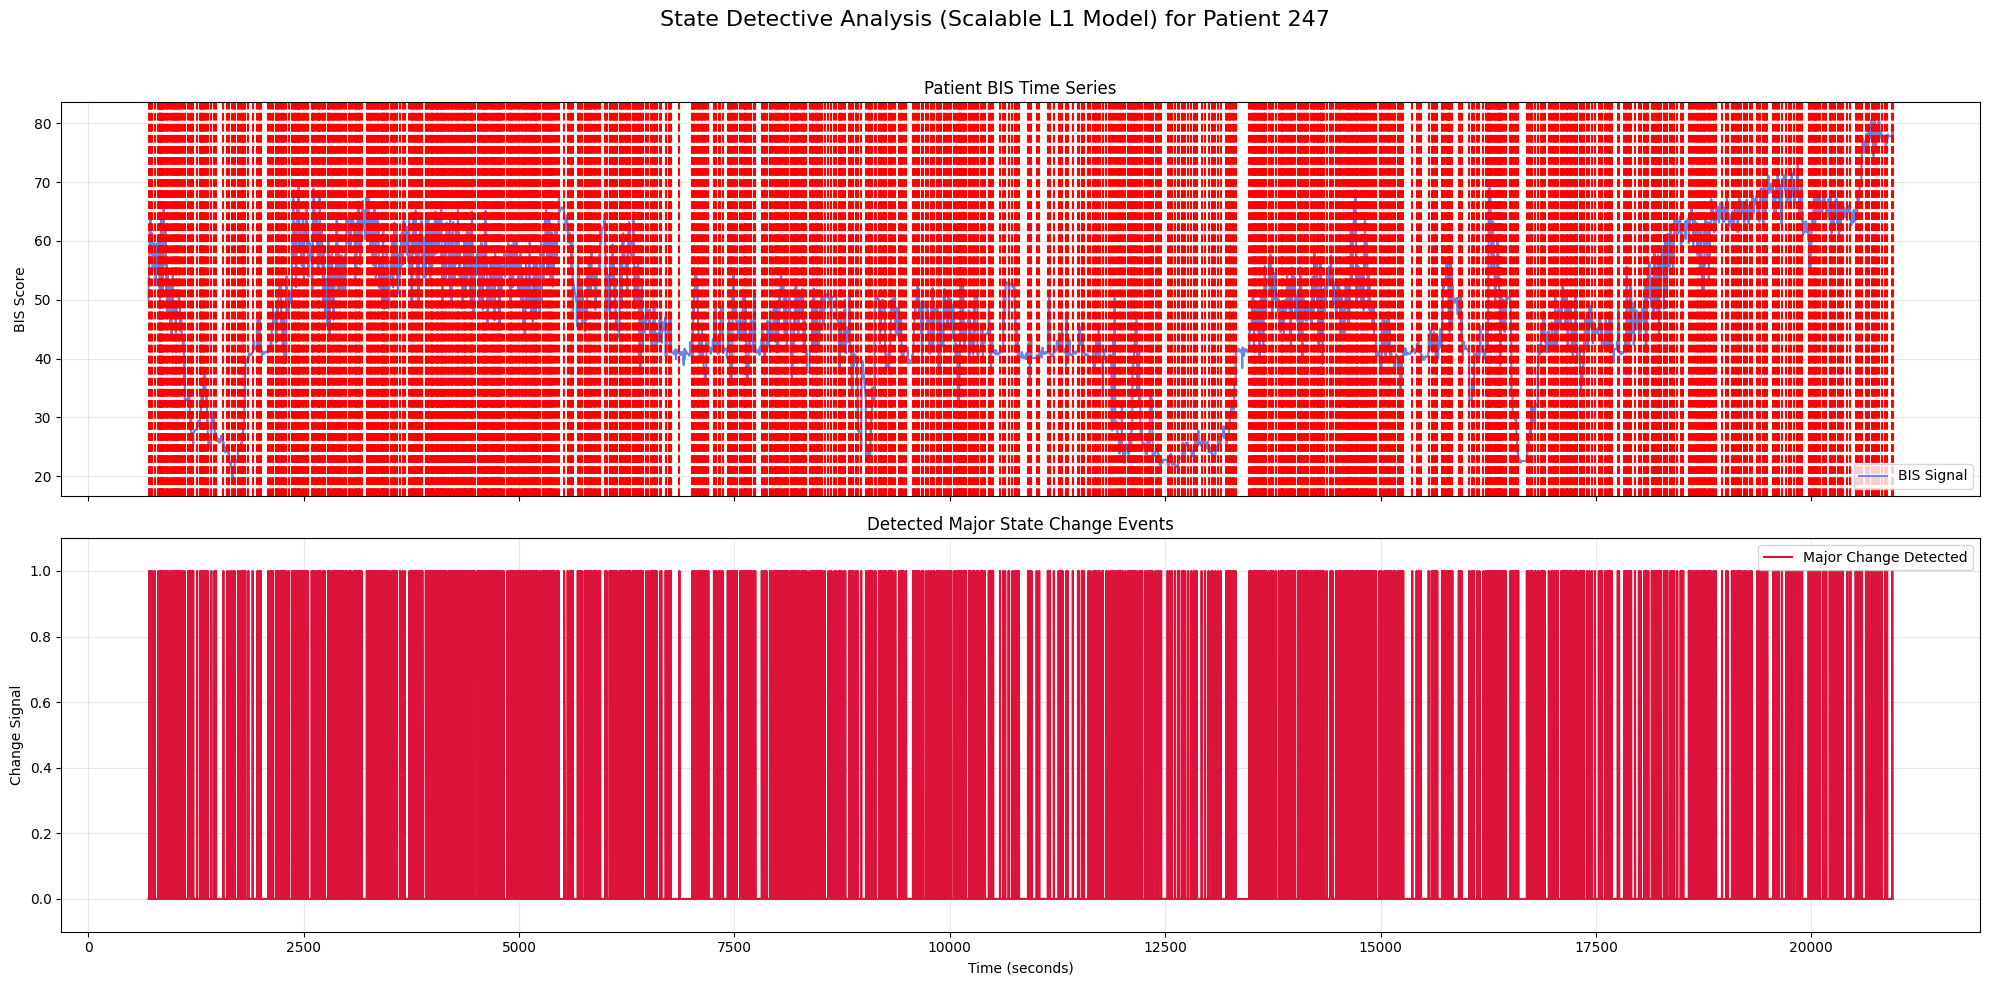

In [ ]:
# --- The State Detective: Change Point Detection v4 (Scalable) ---

# Step 1: Install necessary libraries
!pip install ruptures pandas numpy matplotlib seaborn google-colab --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

# --- 1. Setup and Isolate a Single Patient ---
print("--- Setting up and isolating a single patient for analysis ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))

# Re-run the stratified split logic to get a consistent val_id
patient_row_counts = Counter()
for file_path in batch_files:
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())
patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')
_, val_ids = train_test_split(
    available_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)

target_patient_id = 247
print(f"Selected Patient ID for analysis: {target_patient_id}")

# Load all data for this single patient
patient_df_list = []
for file_path in tqdm(batch_files, desc=f"Loading data for Patient {target_patient_id}"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    patient_chunk = df_chunk[df_chunk['patient_id'] == target_patient_id]
    if not patient_chunk.empty:
        patient_df_list.append(patient_chunk)

patient_df = pd.concat(patient_df_list).sort_values('Time')
signal = patient_df['BIS/BIS'].values
print(f"Successfully loaded {len(signal)} data points for the patient.")


# --- 2. Change Point Detection with a Scalable Algorithm ---
print("\n--- Detecting major change points with a memory-efficient model... ---")

# THE FIX: Retreat from the memory-intensive "rbf" model to the robust and scalable "l1" model.
# The "l1" cost function detects changes in the median and is much less demanding on RAM.
algo = rpt.Pelt(model="l1").fit(signal)

# We can now use a penalty value that is appropriate for this cost function.
PENALTY_VALUE = 5
change_points = algo.predict(pen=PENALTY_VALUE)

# Convert the list of change point locations into a time-series "probability" score for plotting
change_scores = np.zeros(len(signal))
for cp in change_points:
    if cp < len(signal):
        change_scores[cp-1] = 1.0

print(f"Detected {len(change_points)-1} major change points with penalty={PENALTY_VALUE}.")


# --- 3. Visualize the Results ---
print("\n--- Plotting the results... ---")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
fig.suptitle(f'State Detective Analysis (Scalable L1 Model) for Patient {target_patient_id}', fontsize=16)

# Plot 1: The original BIS signal
ax1.plot(patient_df['Time'], signal, label='BIS Signal', color='royalblue', alpha=0.8)
ax1.set_ylabel('BIS Score')
ax1.set_title('Patient BIS Time Series')

# Overlay the detected change points as vertical lines for clarity
for cp in change_points:
    ax1.axvline(x=patient_df['Time'].iloc[cp-1], color='red', linestyle='--', linewidth=1.5)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: The Change Point "Spikes"
ax2.plot(patient_df['Time'], change_scores, label='Major Change Detected', color='crimson')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Change Signal')
ax2.set_title('Detected Major State Change Events')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(-0.1, 1.1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()